## Nuclear Masses

In [1]:
import scipy.stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import read as rd
import emcee
from tqdm import tqdm
import corner


### Bayesian Inference

In [2]:
df = rd.read()
N = np.array(df["N"])
Z = np.array(df["Z"])
BE = np.array(df["binding"])*10**(-3)
BE_err = np.array(df["unc_binding"])*10**(-3)

In [20]:
def model(a_v,a_s,a_c,a_a, a_p,N,Z):
    A = N + Z
    #Coulomb can be Z*(Z-1) or Z**2
    ret = (a_v*A - a_s*A**(2/3) - a_c*Z*(Z-1)/(A**(1/3)) - a_a*((N-Z)**2)/A)
    addend = (a_p*A**(-3/4))
    ret += np.logical_and((N%2 == 0), (Z%2 == 0)) * addend
    ret -= np.logical_and((N%2 == 1), (Z%2 == 1)) * addend
    return ret/A

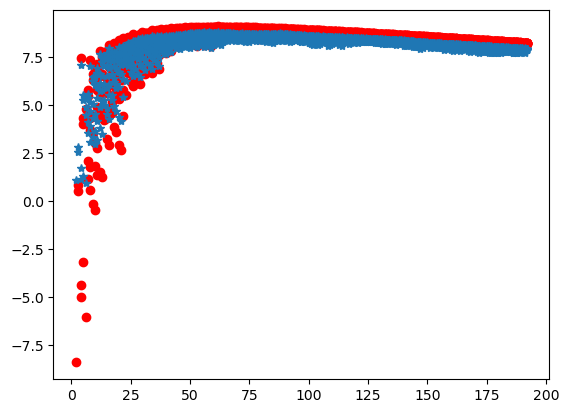

In [21]:
n_points = 2000
A = N +Z
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_th = 16
a_s_th = 18
a_c_th = 0.7
a_a_th = 24
a_p_th = 34

BE_th = model(a_v_th, a_s_th, a_c_th, a_a_th, a_p_th, N, Z)
plt.scatter(A[:n_points], BE_th[:n_points], color = 'red')

## EMCEE

In [22]:
# Parameters
param_names = ['a_v', 'a_s', 'a_c', 'a_a', 'a_p']

def loglikelihood(params):
    (a_v, a_s, a_c, a_a, a_p) = params
    log_like = -np.sum(((model(a_v, a_s, a_c, a_a, a_p, N, Z) - BE)/BE_err)**2 + np.log(2*np.pi*BE_err**2)) / 2. 
    return log_like
    
def prior(params):
    (a_v, a_s, a_c, a_a, a_p) = params

    if (
        0 < a_v < 50 and
        0 < a_s < 50 and
        0 < a_c < 3 and
        0 < a_a < 40 and
        0 < a_p < 50
    ):
        return 0

    return -np.inf

def log_post(params):
    if not np.isfinite(prior(params)):
        return -np.inf
    return loglikelihood(params) + prior(params)

In [23]:
ndim = 5
nwalkers = 30

p0 = np.array([0, 0, 0, 0, 0]) + np.random.rand(nwalkers, ndim) * np.array(
    [50, 50, 3, 40, 50]
)

In [24]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_post, args=())
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [02:30<00:00, 66.51it/s]


State([[12.36525951 10.32908914  0.29174357 22.11042428 10.80263114]
 [12.36525958 10.32908926  0.29174352 22.11042796 10.80263139]
 [12.36525957 10.32908908  0.29174357 22.11042697 10.80263283]
 [12.36525944 10.32908924  0.29174354 22.11042412 10.80263094]
 [12.36525919 10.32908848  0.29174349 22.11042753 10.80263236]
 [12.36526039 10.32909087  0.2917437  22.11042399 10.80263086]
 [12.36526001 10.32908996  0.29174364 22.1104245  10.80263141]
 [12.36526103 10.32909214  0.29174383 22.11041785 10.80263111]
 [12.36525949 10.32908907  0.29174352 22.11042573 10.8026308 ]
 [12.36526037 10.32909096  0.29174368 22.11042126 10.80263098]
 [12.36525959 10.32908943  0.29174356 22.110424   10.80263189]
 [12.36526006 10.32909013  0.29174367 22.11042342 10.80263107]
 [12.36526003 10.32909018  0.29174365 22.11042441 10.8026306 ]
 [12.3652595  10.32908903  0.29174358 22.11042397 10.80263252]
 [12.36525979 10.32908956  0.2917436  22.11042475 10.80263174]
 [12.36525905 10.3290883   0.29174347 22.11042951

Text(0.5, 0, 'step number')

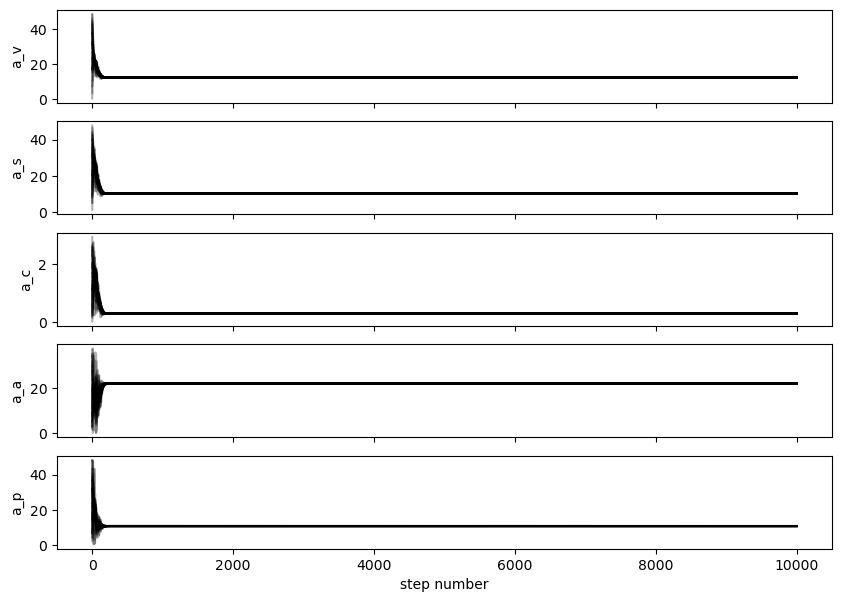

In [25]:
fig, axs = plt.subplots(5, 1, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()

for index, ax in enumerate(axs):
    ax.plot(samples[:, :, index], "k", alpha=0.3)
    ax.set_ylabel(["a_v", "a_s", "a_c", "a_a", "a_p"][index])

axs[-1].set_xlabel("step number")

Quantiles:
[(0.025, np.float64(12.36525904647396)), (0.5, np.float64(12.365259791661323)), (0.975, np.float64(12.365260542328086))]
Quantiles:
[(0.025, np.float64(10.329088265642678)), (0.5, np.float64(10.329089684327503)), (0.975, np.float64(10.32909109670672))]
Quantiles:
[(0.025, np.float64(0.2917434760716022)), (0.5, np.float64(0.2917436073615849)), (0.975, np.float64(0.29174373956387456))]
Quantiles:
[(0.025, np.float64(22.11042115942727)), (0.5, np.float64(22.11042457345748)), (0.975, np.float64(22.11042802819741))]
Quantiles:
[(0.025, np.float64(10.802629866961643)), (0.5, np.float64(10.802631540119036)), (0.975, np.float64(10.802633199671115))]


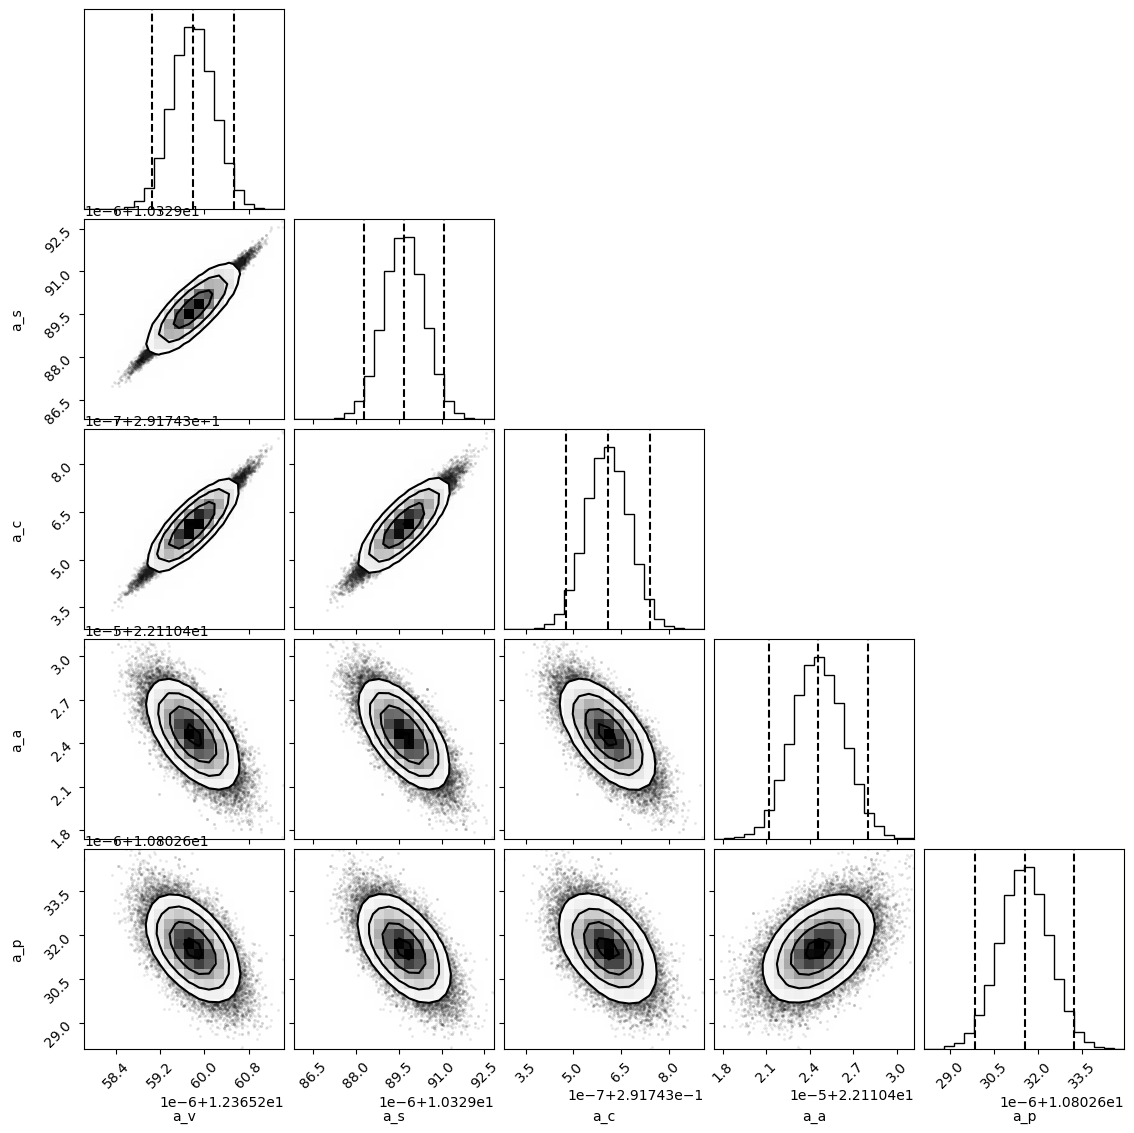

In [28]:
flat_samples = sampler.get_chain(discard=5000, thin=3, flat=True)
fig = corner.corner(flat_samples, labels=["a_v", "a_s", "a_c", "a_a", "a_p"], verbose= True, plot_contours=True, quantiles=[0.025, 0.5, 0.975], smooth=True)

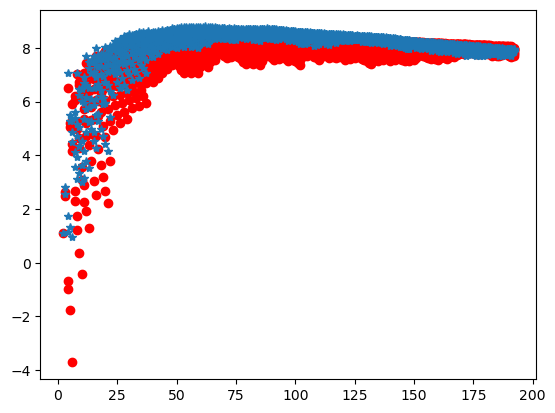

In [27]:
A = N + Z
n_points = 2000
plt.errorbar(A[:n_points], BE[:n_points], BE_err[:n_points], marker = "*" , ls = " ")

a_v_best = 12
a_s_best = 10
a_c_best = 0.3
a_a_best = 22
a_p_best = 10

BE_best = model(a_v_best, a_s_best, a_c_best, a_a_best, a_p_best, N, Z)
plt.scatter(A[:n_points], BE_best[:n_points], color = 'red')